## Fastbook Sandbox

In [1]:
import torch
import fastai
import matplotlib.pyplot as plt
import numpy as np

In [2]:

ex = torch.rand(2, 2, 2)* 0.5
ax = torch.rand(2, 2, 2)* -1
print(ex.shape)
print(ax.shape)
ax

torch.Size([2, 2, 2])
torch.Size([2, 2, 2])


tensor([[[-0.2472, -0.8593],
         [-0.0584, -0.7936]],

        [[-0.8561, -0.5975],
         [-0.2493, -0.7052]]])

In [3]:
def mnist_distance(a,b): return (b-a).abs().mean()
mnist_distance(ex, ax)

tensor(0.7525)

## Pytorch can derivate any function in any point

In [4]:
xt = torch.tensor(3.).requires_grad_()

In [5]:
def f(x): return x**2
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [6]:
yt.backward()

In [7]:
xt.grad

tensor(6.)

In [8]:
xt = torch.tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [9]:
def f(x): return (x**2).sum()
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [10]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

## SDG quadratic example

In [11]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

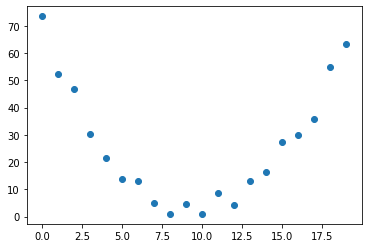

In [12]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [13]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [14]:
def mse(preds, targets): return ((preds-targets)**2).mean()

In [15]:
params = torch.randn(3).requires_grad_()

In [16]:
params

tensor([-0.7132, -0.9853, -0.6441], requires_grad=True)

In [17]:
??to_np

Object `to_np` not found.


In [18]:
ex = torch.rand(2, 4)* 0.5
ax = torch.rand(2, 4)* -1
ex, ax

(tensor([[0.3839, 0.3588, 0.3787, 0.2733],
         [0.1367, 0.2690, 0.4368, 0.4480]]),
 tensor([[-0.5053, -0.3416, -0.5930, -0.0969],
         [-0.1916, -0.7669, -0.5836, -0.5222]]))

In [19]:
r = torch.tensor([1]*len(ex) + [0]*len(ax)).unsqueeze(1)
r

tensor([[1],
        [1],
        [0],
        [0]])

The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together, and then the second item in each passed iterator are paired together etc.

In [20]:
qx = torch.rand(2,2)* 0.5
px = torch.rand(2,2)* -1
dset = list(zip(qx, px))
dset


[(tensor([0.1131, 0.4942]), tensor([-0.4437, -0.8260])),
 (tensor([0.4036, 0.1527]), tensor([-0.1782, -0.2517]))]

In [21]:
list(ex)
x,y = dset[0]
x, y

(tensor([0.1131, 0.4942]), tensor([-0.4437, -0.8260]))

## Matrix Multiplication

In Python, matrix multiplication is represented with the @ operator.

In [22]:
r = x@y
r

tensor(-0.4584)

In [23]:
r = 1/(1+torch.exp(-x))
r

tensor([0.5283, 0.6211])

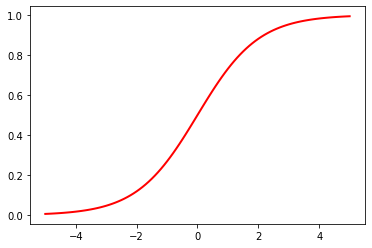

In [24]:
x = torch.range(-5,5,0.1)
def sigmoid(x): return 1/(1+torch.exp(-x))
plt.plot(x, sigmoid(x), color='red', lw=2)

In [42]:
a = np.array([[1, 2],[3, 4]])
b = np.array([[5, 6],[7, 8]])
print(a@b)
print(np.matmul(a,b))
print(np.dot(a,b))
print(a*b)

[[19 22]
 [43 50]]
[[19 22]
 [43 50]]
[[19 22]
 [43 50]]
[[ 5 12]
 [21 32]]


In [86]:
a = torch.tensor([[1, 2, 3],[3, 4, 5]])
print('a.size() ', a.size())
#print('a.shape() ',a.shape())
#print('Rank: ' len(a.shape)
b = torch.tensor([[5, 6],[7, 8],[9, 10]])
c = torch.tensor([[5, 6, 7], [8, 9, 10]])
print('b.size() ', b.size())
print('c.size() ', c.size())
print(a@b)
print(torch.mm(a,b))
print(torch.matmul(a,b))
# print(a*b) element-wise matrix multiplication (Hadamard product).  Works if shape is the same for a and b
print(a*c)
ac = a*c
print('ac.size() ', ac.size())

a.size()  torch.Size([2, 3])
b.size()  torch.Size([3, 2])
c.size()  torch.Size([2, 3])
tensor([[ 46,  52],
        [ 88, 100]])
tensor([[ 46,  52],
        [ 88, 100]])
tensor([[ 46,  52],
        [ 88, 100]])
tensor([[ 5, 12, 21],
        [24, 36, 50]])
ac.size()  torch.Size([2, 3])


```python
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()
```